In [134]:
import numpy as np
import scipy
from scipy import signal, optimize
import pandas as pd

import warnings

from matplotlib import pyplot as plt
import seaborn as sns

import theory
import utility
from mapping import qam_sym2iq_map, qam_mapping, qam_demapping, qam_order2bits, qam_simmetry_bits, qam_vh_bits, gray_code
from pcs import ccdm_encode, ccdm_decode, ccdm_make_cfg_min_bits, ccdm_make_cfg_probability, Comb, qam_optimal_p0

In [233]:
# Main parameters
N_sym = int(4e5)  # Length of signal
M = 16 # Modulation order
C = 3.5
Mbits = qam_order2bits(M)
constel = qam_sym2iq_map(M)
v_bit, h_bit = qam_vh_bits(M)

# shaping
simulation_on = {
    'none': True,
    'ideal': True,
    'ccdm': True
}
p0, p1 = qam_optimal_p0(3.5)
ccdm_cfg = ccdm_make_cfg_min_bits(3*128, 4*128)
#ccdm_cfg = ccdm_make_cfg_probability(3*32, 4*32, p0)

# tx operation
tx_data = {}
for sh_type in simulation_on.keys():
    if True:#simulation_on[sh_type]:
        tx_data[sh_type] = pd.Series(dtype=object)

# Signal generation

# shaping 'none'
tx_data['none']['bit_stream_mapping'] = np.random.choice([0, 1], (Mbits*N_sym, ))
tx_data['none']['X'] = qam_mapping(tx_data['none'].bit_stream_mapping, M)


# shaping ideal
tx_data['ideal']['vh_bits'] = np.random.choice([0, 1], (2*N_sym, ))

# apply pcs for amplitude bits
tx_data['ideal']['amp_bits'] = (np.random.rand((Mbits-2)*N_sym) > p0).astype(int)

tx_data['ideal']['v_bits_ind'] = np.arange(v_bit, N_sym * Mbits, Mbits)
tx_data['ideal']['h_bits_ind'] = np.arange(h_bit, N_sym * Mbits, Mbits)
tx_data['ideal']['amp_bits_ind'] = np.setdiff1d(
    np.arange(N_sym*Mbits), 
    np.hstack([tx_data['ideal'].v_bits_ind, tx_data['ideal'].h_bits_ind]), 
    assume_unique=True
)

tx_data['ideal']['bit_stream_mapping'] = np.zeros(N_sym * Mbits, dtype=int)

tx_data['ideal'].bit_stream_mapping[tx_data['ideal'].v_bits_ind] = \
    tx_data['ideal'].vh_bits[:tx_data['ideal'].vh_bits.size//2]

tx_data['ideal'].bit_stream_mapping[tx_data['ideal'].h_bits_ind] = \
    tx_data['ideal'].vh_bits[tx_data['ideal'].vh_bits.size//2:]

tx_data['ideal'].bit_stream_mapping[tx_data['ideal'].amp_bits_ind] = tx_data['ideal'].amp_bits

tx_data['ideal']['X'] = qam_mapping(tx_data['ideal'].bit_stream_mapping, M)


# shaping 'ccdm'
N_sym_ccdm = N_sym + (ccdm_cfg['c_sz'] - N_sym % ccdm_cfg['c_sz'])

tx_data['ccdm']['vh_bits'] = np.random.choice([0, 1], (2*N_sym_ccdm, ))

tx_data['ccdm']['amp_bits_nc'] = np.random.choice([0, 1], (N_sym_ccdm*(Mbits-2)*ccdm_cfg['d_sz']//ccdm_cfg['c_sz'], ))
tx_data['ccdm']['amp_bits'] = ccdm_encode(
    tx_data['ccdm'].amp_bits_nc, 
    ccdm_cfg['one_bits'], 
    ccdm_cfg['d_sz'], 
    ccdm_cfg['c_sz']
)

tx_data['ccdm']['v_bits_ind'] = np.arange(v_bit, N_sym_ccdm * Mbits, Mbits)
tx_data['ccdm']['h_bits_ind'] = np.arange(h_bit, N_sym_ccdm * Mbits, Mbits)
tx_data['ccdm']['amp_bits_ind'] = np.setdiff1d(
    np.arange(N_sym_ccdm*Mbits), 
    np.hstack([tx_data['ccdm'].v_bits_ind, tx_data['ccdm'].h_bits_ind]), 
    assume_unique=True
)

tx_data['ccdm']['bit_stream_mapping'] = np.zeros(N_sym_ccdm * Mbits, dtype=int)

tx_data['ccdm'].bit_stream_mapping[tx_data['ccdm'].v_bits_ind] = \
    tx_data['ccdm'].vh_bits[:tx_data['ccdm'].vh_bits.size//2]

tx_data['ccdm'].bit_stream_mapping[tx_data['ccdm'].h_bits_ind] = \
    tx_data['ccdm'].vh_bits[tx_data['ccdm'].vh_bits.size//2:]

tx_data['ccdm'].bit_stream_mapping[tx_data['ccdm'].amp_bits_ind] = tx_data['ccdm'].amp_bits

tx_data['ccdm']['X'] = qam_mapping(tx_data['ccdm'].bit_stream_mapping, M)


<IPython.core.display.Javascript object>


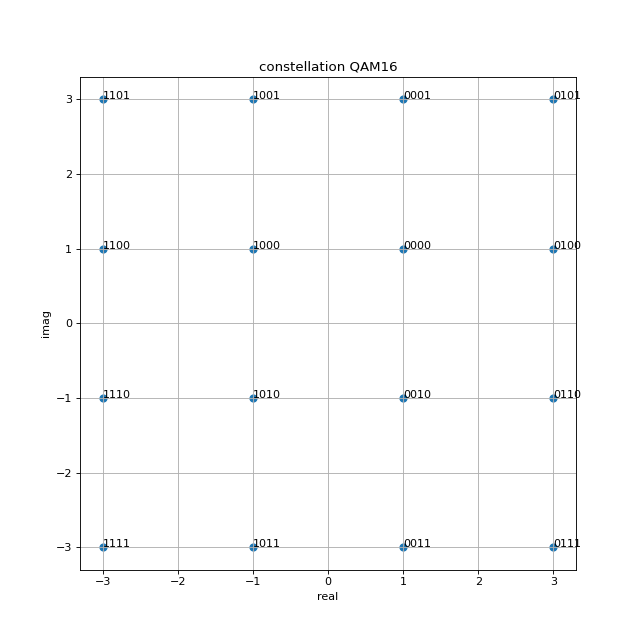

Text(0.5, 1.0, 'constellation QAM16')

In [234]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))

plt.scatter(constel.real, constel.imag, s=40)
plt.grid(True)

plot_zero_bits_cnt = False
for i in range(M):
    if not plot_zero_bits_cnt:
        plt.text(constel[i].real, constel[i].imag, ('{:0'+str(Mbits)+'b}').format(i))
    else:
        v_bit, h_bit = qam_vh_bits(M)
        plt.text(constel[i].real, constel[i].imag, 
                 ('{}').format((('{:0'+str(Mbits)+'b}').format(i)[1:Mbits//2]+('{:0'+str(Mbits)+'b}').format(i)[Mbits//2+1:Mbits]).count('0')))
    

plt.xlabel('real')
plt.ylabel('imag')
plt.title('constellation QAM{}'.format(M))

# Plot BER/SNR (OSNR)

In [236]:
Fs = 10e9  # Frequency band in Hz

snr_db_range = np.linspace(0, 20, 20)
osnr_db_range = utility.snr2osnr_db(snr_db_range, Fs)
EbN0_db_range = utility.EbN0_db(snr_db_range, M)
ber_theory = theory.theory_ber(snr_db_range, M)
ber_theory_qpsk = theory.theory_ber(snr_db_range, 4)

rx_data = {}
for sh_type in simulation_on.keys():
    if simulation_on[sh_type]:
        rx_data[sh_type] = pd.Series({'ber_sim': np.zeros(snr_db_range.size, dtype=float)}, dtype=object)
        if sh_type in ['ccdm', 'ideal']:
            rx_data[sh_type]['ber_vh'] = np.zeros(snr_db_range.size, dtype=float)
            rx_data[sh_type]['ber_amp'] = np.zeros(snr_db_range.size, dtype=float)

for sh_type in rx_data.keys():
    for i in range(len(snr_db_range)):
        snr_db = snr_db_range[i]
        # Generating noise
        #noise = utility.db2A(-snr_db) * (np.random.randn(X.size) + 1j * np.random.randn(X.size)) / np.sqrt(2) * np.sqrt(np.var(constel))
        noise = utility.db2A(-snr_db)/ np.sqrt(2) * np.sqrt(np.var(tx_data[sh_type].X)) * \
                (np.random.randn(tx_data[sh_type].X.size) + 
                1j * np.random.randn(tx_data[sh_type].X.size))
        
        X_noisy = tx_data[sh_type].X + noise

        # Hard slicing
        bit_stream_demapping = qam_demapping(X_noisy, M)
        
        # BER calculation
        rx_data[sh_type].ber_sim[i] = np.mean(np.abs(bit_stream_demapping - tx_data[sh_type].bit_stream_mapping))
            
        if sh_type in ['ideal', 'ccdm']:
            v_bits = bit_stream_demapping[tx_data[sh_type].v_bits_ind]
            h_bits = bit_stream_demapping[tx_data[sh_type].h_bits_ind]
            vh_bits = np.hstack([v_bits, h_bits])
            
            amp_bits = bit_stream_demapping[tx_data[sh_type].amp_bits_ind]
            rx_data[sh_type].ber_vh[i] = np.mean(np.abs(tx_data[sh_type].vh_bits - vh_bits))
            rx_data[sh_type].ber_amp[i] = np.mean(np.abs(tx_data[sh_type].amp_bits - amp_bits))

            


<IPython.core.display.Javascript object>


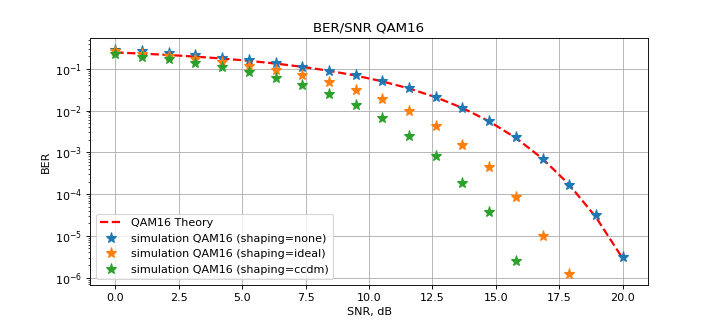

<IPython.core.display.Javascript object>


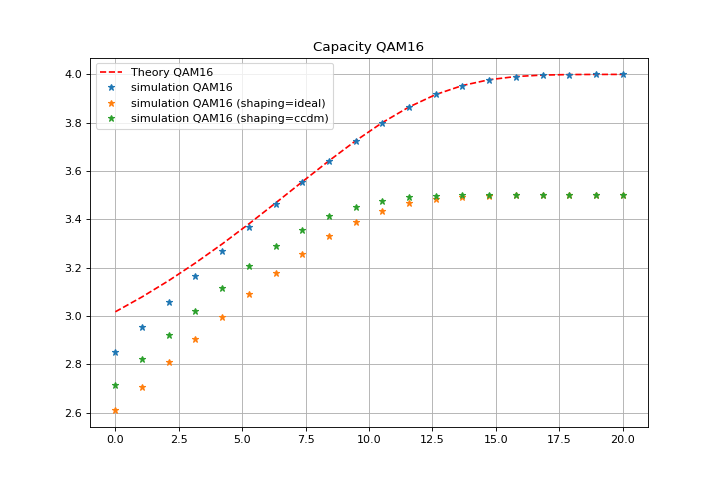

In [237]:
%matplotlib notebook

# Plotting BER vs SNR curve
fig = plt.figure(figsize=(9, 4))

#plt.semilogy(snr_db_range, ber_theory_qpsk, 'g--', linewidth=2, label='QPSK theory')
plt.semilogy(snr_db_range, ber_theory, 'r--', linewidth=2, label="QAM{} Theory".format(M))

for sh_type in rx_data.keys():
    plt.semilogy(
        snr_db_range, 
        rx_data[sh_type].ber_sim, 
        '*', markersize=10, 
        label='simulation QAM{} (shaping={})'.format(M, sh_type)
    )
    
plt.xlabel('SNR, dB')
plt.ylabel('BER')
plt.legend()
plt.grid(True)
plt.title('BER/SNR QAM{}'.format(M))

# plot Capacity
fig = plt.figure(figsize=(9, 6))

plt.plot(snr_db_range, Mbits*(1-ber_theory), 'r--', label='Theory QAM{}'.format(M))

for sh_type in rx_data.keys():
    if sh_type == 'none':
        plt.plot(snr_db_range, Mbits*(1-rx_data[sh_type].ber_sim), '*', label='simulation QAM{}'.format(M))
    
    elif sh_type == 'ideal':
        plt.plot(
            snr_db_range, 
            2*(1-rx_data[sh_type].ber_vh) + (C-2)*(1-rx_data[sh_type].ber_amp), 
            '*', 
            label='simulation QAM{} (shaping={})'.format(M, sh_type))
    
    elif sh_type == 'ccdm':
        plt.plot(
            snr_db_range, 
            2*(1-rx_data[sh_type].ber_vh) + ((Mbits-2)*ccdm_cfg['d_sz']/ccdm_cfg['c_sz'])*(1-rx_data[sh_type].ber_amp), 
            '*', 
            label='simulation QAM{} (shaping={})'.format(M, sh_type))
        
plt.grid(True)
plt.title("Capacity QAM{}".format(M))
plt.legend()

<IPython.core.display.Javascript object>


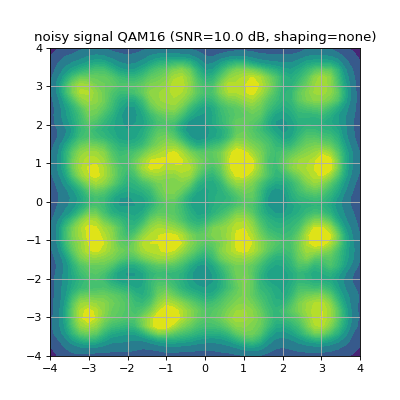

<IPython.core.display.Javascript object>


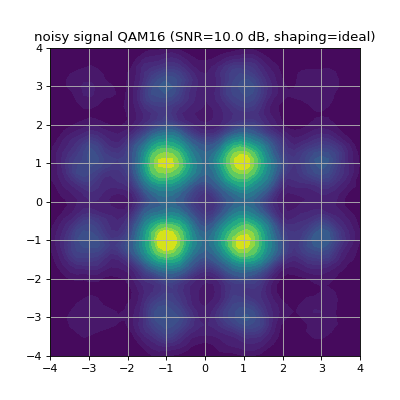

<IPython.core.display.Javascript object>


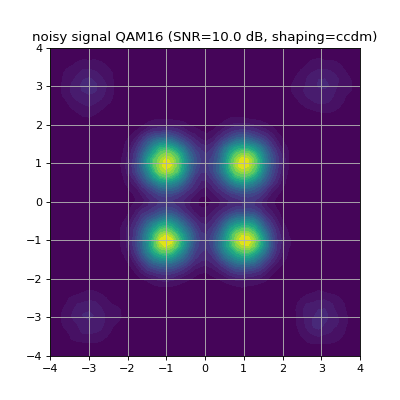

In [238]:
%matplotlib notebook

snr_db = 10
data_mx_sz = int(5e4)
for sh_type in tx_data.keys():
    sz_to_plt = min(data_mx_sz, tx_data[sh_type].X.size)
    X = tx_data[sh_type].X[:sz_to_plt]
    noise = utility.db2A(-snr_db)/ np.sqrt(2) * np.sqrt(np.var(X)) * \
            (np.random.randn(X.size) + 
            1j * np.random.randn(X.size))

    X_noisy = X + noise
    
    fig = plt.figure(figsize=(5, 5))
    
    plt.grid(True)
    plt.title('noisy signal QAM{} (SNR={:.1f} dB, shaping={})'.format(M, snr_db, sh_type))
    sns.kdeplot(
        x=X_noisy.real[:50000], y=X_noisy.imag[:50000],
        fill=True, thresh=0, levels=20, cmap="viridis", bw_adjust=0.5, gridsize=64
    )
    plt.xlim((-np.sqrt(M), np.sqrt(M)))
    plt.ylim((-np.sqrt(M), np.sqrt(M)))